In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.3 MB/s eta 0:00:00


In [5]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.8 MB/s eta 0:00:00


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import optuna

from category_encoders import WOEEncoder

In [7]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')
addition_data = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')

train_df['is_generated'] = 1
test_df['is_generated'] = 1
addition_data['is_generated'] = 0

In [8]:
train_df = train_df.drop(527).drop(1398).reset_index(drop=True)

In [9]:
train_df = train_df.drop('id', axis=1)
train_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,is_generated
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,1,10,2,3,10,0,7,8,0,1
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,1,4,3,3,4,2,0,3,0,1
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,2,4,3,3,3,2,1,2,0,1
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,0,15,1,1,6,0,0,2,0,1
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,0,31,0,3,31,14,4,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,30,Travel_Rarely,945,Sales,1,3,Life Sciences,1,4,Female,...,0,10,2,4,10,0,0,8,0,1
1671,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,1,Male,...,1,10,3,4,4,2,1,3,0,1
1672,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,1,2,Male,...,0,1,2,3,1,0,0,0,1,1
1673,36,Travel_Rarely,441,Sales,9,2,Marketing,1,2,Male,...,2,10,3,2,10,3,0,8,0,1


In [10]:
train_df.isna().any()

Age                         False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany

In [11]:
addition_data['Attrition'] = (addition_data['Attrition'] == 'Yes').astype(int)
addition_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_generated
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,80,1,17,3,3,5,2,0,3,0
1466,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,80,1,9,5,3,7,7,1,7,0
1467,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,80,1,6,0,3,6,2,0,3,0
1468,49,0,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,80,0,17,3,2,9,6,0,8,0


<Axes: >

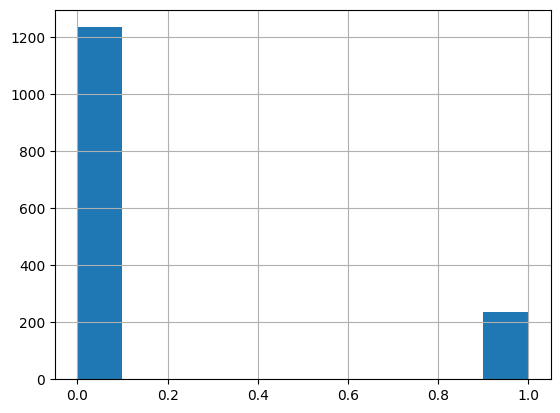

In [12]:
addition_data.Attrition.hist()

In [13]:
addition_data.isna().any()

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [14]:
train_df = pd.concat([train_df, addition_data],axis=0, ignore_index=True)
train_df = train_df.drop('EmployeeNumber', axis=1)
train_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,is_generated
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,1,10,2,3,10,0,7,8,0,1
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,1,4,3,3,4,2,0,3,0,1
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,2,4,3,3,3,2,1,2,0,1
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,0,15,1,1,6,0,0,2,0,1
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,0,31,0,3,31,14,4,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,36,Travel_Frequently,884,Research & Development,23,2,Medical,1,3,Male,...,1,17,3,3,5,2,0,3,0,0
3141,39,Travel_Rarely,613,Research & Development,6,1,Medical,1,4,Male,...,1,9,5,3,7,7,1,7,0,0
3142,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2,Male,...,1,6,0,3,6,2,0,3,0,0
3143,49,Travel_Frequently,1023,Sales,2,3,Medical,1,4,Male,...,0,17,3,2,9,6,0,8,0,0


In [15]:
train_df.isna().any()

Age                         False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany

In [16]:
def is_young(x):
    if x <=25:
        return 1
    else:
        return 0

def young_and_low_daily_rate(x):
    if x['Age'] <= 25 & x['DailyRate'] < 500:
        return 1
    else:
        return 0

def overtime_satisfaction(x):
        if x['OverTime'] == 'Yes':
            return (x['MonthlyIncome'] * (x['StockOptionLevel'] + 0.05) * x['JobSatisfaction'])/x['Age']
        else:
            return (x['MonthlyIncome'] * (x['StockOptionLevel'] + 1.05) * x['JobSatisfaction'])/x['Age']

# def calculate_experience_ratios(df):
#     '''
#     Calculates multiple experience ratios...
#     '''
#     df['Equivalent_Salary'] = df['MonthlyIncome'] / (df['TotalWorkingYears'] + 1)
#     df['Working_Years'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)
#     df['Avg_Years_Per_Company'] = df['TotalWorkingYears'] / (df['NumCompaniesWorked'] + 1)
#     df['Education_To_Salary'] = df['MonthlyIncome'] / (df['Education'] + 1)
#     df['Manager_Familiarity'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)
#     df['Performance_Fairness'] = df['PercentSalaryHike'] / df['PerformanceRating']
#     return df

In [17]:
df = pd.concat([train_df, test_df], axis=0)
df = df.drop(["EmployeeCount", "Over18", "StandardHours"], axis=1)

df['is_young'] = df['Age'].apply(lambda x: is_young(x))
df['young_and_underpaid'] = df.apply(lambda x: young_and_low_daily_rate(x), axis = 1)
df['worklife_stock'] = df.apply(lambda x: x['WorkLifeBalance'] + x['StockOptionLevel'], axis = 1)

df['income_satisfaction'] = df.apply(lambda x: x['JobSatisfaction'] * x['MonthlyIncome'], axis = 1)
df['income_level_environ_job_sat'] = df.apply(lambda x: x['EnvironmentSatisfaction']*x['JobSatisfaction'] * (x['MonthlyIncome']/x['JobLevel']), axis = 1)
df['overtime_stock'] = df.apply(lambda x: overtime_satisfaction(x), axis = 1)

# df = calculate_experience_ratios(df)

# df = pd.get_dummies(df)
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,YearsWithCurrManager,Attrition,is_generated,id,is_young,young_and_underpaid,worklife_stock,income_satisfaction,income_level_environ_job_sat,overtime_stock
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,4,Male,42,...,8,0.0,1,NaN,0,0,4,10384,41536.0,302.866667
1,35,Travel_Rarely,921,Sales,8,3,Other,1,Male,46,...,3,0.0,1,NaN,0,0,4,2899,2899.0,169.798571
2,32,Travel_Rarely,718,Sales,26,3,Marketing,3,Male,80,...,2,0.0,1,NaN,0,0,5,18508,27762.0,1764.043750
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,3,Female,40,...,2,0.0,1,NaN,0,0,1,5347,8020.5,147.746053
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,2,Female,37,...,10,1.0,1,NaN,0,0,3,19033,7613.2,19.033000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,31,Travel_Rarely,755,Sales,1,1,Life Sciences,3,Male,81,...,0,NaN,1,2791.0,0,0,4,18712,56136.0,1237.406452
1115,40,Travel_Rarely,654,Research & Development,26,5,Medical,3,Male,96,...,8,NaN,1,2792.0,0,0,4,24880,37320.0,1275.100000
1116,42,Travel_Frequently,884,Research & Development,1,4,Medical,2,Female,65,...,2,NaN,1,2793.0,0,0,3,5238,5238.0,255.664286
1117,25,Travel_Frequently,1469,Sales,1,2,Technical Degree,3,Male,68,...,3,NaN,1,2794.0,1,1,4,19196,28794.0,1574.072000


In [18]:
features = ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'is_generated', 'id', 'is_young',
       'young_and_underpaid', 'worklife_stock', 'income_satisfaction',
        'income_level_environ_job_sat', 'overtime_stock']
cat_features = ['BusinessTravel', 'Department','Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
               'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus','NumCompaniesWorked', 'OverTime',
               'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
                'WorkLifeBalance', 'YearsAtCompany','is_young', 'young_and_underpaid']

In [19]:
woe = WOEEncoder(drop_invariant=True, randomized = True)
for col in cat_features:
    df[col] = df[col].astype(str)
woe.fit(df[features][:-len(test_df)], df['Attrition'][:-len(test_df)], cols = cat_features)
X = woe.transform(df[features])
X['Attrition'] = df['Attrition']
df = X

In [ ]:
# y.shape

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# num_cols = ['age', 'avg_glucose_level', 'bmi']

y = df['Attrition']
df = df.drop(['id','Attrition'], axis=1)

df[df.columns] = scaler.fit_transform(df[df.columns])

In [21]:
train_df = df.iloc[:-len(test_df),:]
train_df['Attrition'] = y[:-len(test_df)]
test_df = df.iloc[-len(test_df):,:].reset_index(drop=True)

X = train_df.drop(['Attrition'], axis=1)
y = train_df.Attrition
X_test = test_df

<ipython-input-21-52acbadb9724>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Attrition'] = y[:-len(test_df)]


In [ ]:
# X1 = X[:500]
# y1 = y[:500]
# X = X[500:]
# y = y[500:]

# Catboost

In [ ]:
# from sklearn.model_selection import train_test_split
# import catboost
# from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# from sklearn.model_selection import cross_val_score

# def catboost_objective(trial):
# #     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
# #     depth = trial.suggest_int('depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     subsample = trial.suggest_float('subsample', 0, 1)
#     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 100)
#     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)

#     model = catboost.CatBoostRegressor(
#         learning_rate= 0.2238051305181816,
#         depth= 3,
#         n_estimators= 500,
#         verbose= 0,
#         rsm =  0.5,
#         subsample = subsample,
#         l2_leaf_reg = l2_leaf_reg,
#         min_data_in_leaf= min_data_in_leaf,
#         random_strength = 0.175,
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(catboost_objective, n_trials= 50)

In [ ]:
# study.best_params

In [23]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.7 MB/s eta 0:00:00


In [24]:
import catboost
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

n_folds = 11
repeats = 10

MAX_ITER = 15000
PATIENCE = 1000
DISPLAY_FREQ = 100

modelsCB = []
predsCB = []

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

MODEL_PARAMS = {
                'random_seed': 1234,
                'iterations': MAX_ITER,
                'early_stopping_rounds': PATIENCE,
                'use_best_model': True,
#                 'eval_metric': 'AUC',
                'eval_metric': 'RMSE',
                'verbose': 1000,

                 'depth': 3, #3 2
                 'learning_rate': 0.2238051305181816, #0.2238051305181816, #0.01 0.45
                 'rsm': 0.5,
                 'subsample': 0.931, #0.1946411784581574, #0.931,
                 'l2_leaf_reg': 69, #39, #69, #69, 4.445
                 'min_data_in_leaf': 20, #74, #20, #20, 1
                 'random_strength': 0.175,
#                  'colsample_bylevel': 0.5504444444444444, #
               }


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

#     model = catboost.CatBoostClassifier(**MODEL_PARAMS)
    model = catboost.CatBoostRegressor(**MODEL_PARAMS)

    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
#           metric_period = DISPLAY_FREQ
         )
    modelsCB.append(model)
    predsCB.append(model.predict(X_test))
    #     eval_predsCB.append(model.predict(X))

0:	learn: 0.3383274	test: 0.3361331	best: 0.3361331 (0)	total: 47.8ms	remaining: 11m 57s
1000:	learn: 0.2088637	test: 0.2874677	best: 0.2840283 (670)	total: 964ms	remaining: 13.5s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.2840283184
bestIteration = 670

Shrink model to first 671 iterations.
0:	learn: 0.3383428	test: 0.3375141	best: 0.3375141 (0)	total: 815us	remaining: 12.2s
1000:	learn: 0.2027805	test: 0.2935573	best: 0.2917197 (682)	total: 939ms	remaining: 13.1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.2917197078
bestIteration = 682

Shrink model to first 683 iterations.
0:	learn: 0.3384296	test: 0.3382246	best: 0.3382246 (0)	total: 801us	remaining: 12s
1000:	learn: 0.2014868	test: 0.3037489	best: 0.2928728 (121)	total: 764ms	remaining: 10.7s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.2928728153
bestIteration = 121

Shrink model to first 122 iterations.
0:	learn: 0.3383687	test: 0.3379871	best: 0.3379

In [ ]:
# from sklearn.model_selection import train_test_split
# import catboost
# from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# from sklearn.model_selection import cross_val_score

# def catboost_cl_objective(trial):
# #     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
# #     depth = trial.suggest_int('depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     subsample = trial.suggest_float('subsample', 0, 1)
#     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 100)
#     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)

#     model = catboost.CatBoostClassifier(
#         learning_rate= 0.2238051305181816,
#         depth= 3,
#         n_estimators= 500,
#         verbose= 0,
#         rsm =  0.5,
#         subsample = subsample,
#         l2_leaf_reg = l2_leaf_reg,
#         min_data_in_leaf= min_data_in_leaf,
#         random_strength = 0.175,
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(catboost_cl_objective, n_trials= 50)

In [ ]:
# study.best_params

In [25]:
MAX_ITER = 15000
PATIENCE = 1000
DISPLAY_FREQ = 100

modelsCBC = []
predsCBC = []

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

MODEL_PARAMS = {
                'random_seed': 1234,
                'iterations': MAX_ITER,
                'early_stopping_rounds': PATIENCE,
                'use_best_model': True,
                'eval_metric': 'AUC',
#                 'eval_metric': 'RMSE',
                'verbose': 1000,

                 'depth': 3, #3 2
                 'learning_rate': 0.2238051305181816, #0.08259958598203335, #0.2238051305181816, #0.01 0.45
                 'rsm': 0.5,
                 'subsample': 0.931, #0.008520274433054455, #0.931,
                 'l2_leaf_reg': 69, #62, #69, #69, 4.445
                 'min_data_in_leaf': 20, #69, #20, #20, 1
                 'random_strength': 0.175,
#                  'colsample_bylevel': 0.5504444444444444, #
               }


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    model = catboost.CatBoostClassifier(**MODEL_PARAMS)
#     model = catboost.CatBoostRegressor(**MODEL_PARAMS)

    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
#           metric_period = DISPLAY_FREQ
         )
    modelsCBC.append(model)
    predsCBC.append(model.predict_proba(X_test)[:, 1])

0:	test: 0.6679124	best: 0.6679124 (0)	total: 2.8ms	remaining: 42s
1000:	test: 0.8584034	best: 0.8612063 (669)	total: 1.34s	remaining: 18.8s
2000:	test: 0.8540434	best: 0.8621406 (1046)	total: 2.67s	remaining: 17.4s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8621405585
bestIteration = 1046

Shrink model to first 1047 iterations.
0:	test: 0.7026887	best: 0.7026887 (0)	total: 1.5ms	remaining: 22.5s
1000:	test: 0.8720025	best: 0.8808263 (334)	total: 1.35s	remaining: 18.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8808263262
bestIteration = 334

Shrink model to first 335 iterations.
0:	test: 0.7980183	best: 0.7980183 (0)	total: 1.16ms	remaining: 17.4s
1000:	test: 0.8090447	best: 0.8542683 (174)	total: 1.32s	remaining: 18.5s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8542682927
bestIteration = 174

Shrink model to first 175 iterations.
0:	test: 0.8058435	best: 0.8058435 (0)	total: 1.23ms	remaining: 18.4s
1000:

# XGBoost

In [ ]:
# def xgboost_objective(trial):
# #     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
# #     max_depth = trial.suggest_int('max_depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     subsample = trial.suggest_float('subsample', 0, 1)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
#     reg_lambda = trial.suggest_int('reg_lambda', 1, 100)

#     model = XGBRegressor(
#         learning_rate= 0.04625397031701272,
#         max_depth= 3,
#         n_estimators= 500,
#         colsample_bytree = colsample_bytree, # 0.95
#         subsample = subsample,
#         reg_lambda = reg_lambda,
# #         verbose= 0
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(xgboost_objective, n_trials= 50)

In [ ]:
# study.best_params

In [26]:
from xgboost import XGBClassifier, XGBRegressor

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

modelsXB = []
predsXB = []

PATIENCE = 200

MODEL_PARAMS = {       'n_estimators': 5000,
                       'learning_rate': 0.04625397031701272, #0.04625397031701272, 0.06733333333333334
                       'max_depth': 3, #3, 29
                       'colsample_bytree': 0.9, #0.12954517333371557, #0.9, #0.9, 0.99
                       'subsample': 1, #0.7426054009856451, #1, #1, 0.99
#                        'min_child_weight': 12, #
#                        'gamma': 0.11888888888888888, #
                       'reg_lambda': 20, #55, #20,
#                        'eval_metric': 'auc',
                       'eval_metric': 'rmse',
                       'early_stopping_rounds': PATIENCE,
#                        'tree_method': 'gpu_hist',
                       'seed': 1
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

#     model = XGBClassifier(**MODEL_PARAMS)
    model = XGBRegressor(**MODEL_PARAMS)

    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXB.append(model)
    predsXB.append(model.predict(X_test))

[0]	validation_0-rmse:0.48685
[100]	validation_0-rmse:0.29844
[200]	validation_0-rmse:0.29503
[300]	validation_0-rmse:0.29419
[400]	validation_0-rmse:0.29388
[500]	validation_0-rmse:0.29362
[600]	validation_0-rmse:0.29378
[700]	validation_0-rmse:0.29338
[800]	validation_0-rmse:0.29350
[900]	validation_0-rmse:0.29319
[1000]	validation_0-rmse:0.29446
[1075]	validation_0-rmse:0.29550
[0]	validation_0-rmse:0.48700
[100]	validation_0-rmse:0.30516
[200]	validation_0-rmse:0.29853
[300]	validation_0-rmse:0.29691
[400]	validation_0-rmse:0.29547
[500]	validation_0-rmse:0.29392
[600]	validation_0-rmse:0.29410
[700]	validation_0-rmse:0.29361
[800]	validation_0-rmse:0.29220
[900]	validation_0-rmse:0.29132
[1000]	validation_0-rmse:0.29131
[1100]	validation_0-rmse:0.29224
[1185]	validation_0-rmse:0.29246
[0]	validation_0-rmse:0.48688
[100]	validation_0-rmse:0.29552
[200]	validation_0-rmse:0.29162
[300]	validation_0-rmse:0.29114
[400]	validation_0-rmse:0.29147
[500]	validation_0-rmse:0.29132
[507]	val

In [ ]:
# def xgboost_cl_objective(trial):
# #     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
# #     max_depth = trial.suggest_int('max_depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     subsample = trial.suggest_float('subsample', 0, 1)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
#     reg_lambda = trial.suggest_int('reg_lambda', 1, 100)

#     model = XGBClassifier(
#         learning_rate= 0.04625397031701272,
#         max_depth= 3,
#         n_estimators= 500,
#         colsample_bytree = colsample_bytree, # 0.95
#         subsample = subsample,
#         reg_lambda = reg_lambda,
#         eval_metric = 'auc',
# #         verbose= 0
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(xgboost_cl_objective, n_trials= 50)

In [ ]:
# study.best_params

In [27]:
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

modelsXBC = []
predsXBC = []

PATIENCE = 200

MODEL_PARAMS = {       'n_estimators': 5000,
                       'learning_rate': 0.04625397031701272, #0.02910875107189472, #0.04625397031701272, 0.06733333333333334
                       'max_depth': 3, #4, #3, 29
                       'colsample_bytree': 0.9, #0.11912735505392935, #0.9, #0.9, 0.99
                       'subsample': 1, #0.7605555695727094, # 1, #1, 0.99
#                        'min_child_weight': 12, #
#                        'gamma': 0.11888888888888888, #
                       'reg_lambda': 20, #17, #20,
                       'eval_metric': 'auc',
#                        'eval_metric': 'rmse',
                       'early_stopping_rounds': PATIENCE,
#                        'tree_method': 'gpu_hist',
                       'seed': 1
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    model = XGBClassifier(**MODEL_PARAMS)
#     model = XGBRegressor(**MODEL_PARAMS)

    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXBC.append(model)
    predsXBC.append(model.predict_proba(X_test)[:, 1])

[0]	validation_0-auc:0.72174
[100]	validation_0-auc:0.80889
[200]	validation_0-auc:0.82726
[300]	validation_0-auc:0.84034
[400]	validation_0-auc:0.84595
[500]	validation_0-auc:0.84667
[600]	validation_0-auc:0.84833
[700]	validation_0-auc:0.85062
[800]	validation_0-auc:0.85467
[900]	validation_0-auc:0.85695
[1000]	validation_0-auc:0.85809
[1100]	validation_0-auc:0.85913
[1200]	validation_0-auc:0.85944
[1300]	validation_0-auc:0.85965
[1400]	validation_0-auc:0.86058
[1500]	validation_0-auc:0.86027
[1600]	validation_0-auc:0.86131
[1700]	validation_0-auc:0.86245
[1800]	validation_0-auc:0.86193
[1890]	validation_0-auc:0.86173
[0]	validation_0-auc:0.64492
[100]	validation_0-auc:0.81397
[200]	validation_0-auc:0.84989
[300]	validation_0-auc:0.85892
[400]	validation_0-auc:0.86370
[500]	validation_0-auc:0.86038
[586]	validation_0-auc:0.86214
[0]	validation_0-auc:0.68689
[100]	validation_0-auc:0.83252
[200]	validation_0-auc:0.84634
[300]	validation_0-auc:0.85061
[400]	validation_0-auc:0.84868
[500

# LGBM

In [ ]:
# def lgbm_objective(trial):
# #     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
# #     max_depth = trial.suggest_int('max_depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     num_leaves = trial.suggest_int('num_leaves', 1, 100)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
#     subsample = trial.suggest_float('subsample', 0, 1)

#     model = LGBMRegressor(
#         learning_rate= 0.04131536309750098,
#         max_depth= 3,
#         n_estimators= 500,
#         num_leaves = num_leaves,
#         colsample_bytree = colsample_bytree,
#         subsample = subsample,
#         subsample_freq = 5,
#         min_child_samples = 36,
#         reg_lambda = 28,
#         metric = 'rmse',
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(lgbm_objective, n_trials= 50)

In [ ]:
# study.best_params

In [28]:
import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=43, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

modelsLB = []
predsLB = []

MODEL_PARAMS = {
                       'learning_rate': 0.04131536309750098,
                       'max_depth': 3,
                       'num_leaves': 90, #80, #90,
                       'colsample_bytree': 0.8, #0.1894464869106461, #0.8,
                       'subsample': 0.9, #0.5730986849967483, #0.9,
                       'subsample_freq': 5,
                       'min_child_samples': 36,
                       'reg_lambda': 28,
                       'n_estimators': 20000,
#                        'metric': 'auc',
                       'metric': 'rmse',
                       'random_state': 2
}

callbacks = [
             lgbm.early_stopping(30, verbose=1),
#              lgbm.log_evaluation(period=0)
            ]

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

#     model = lgbm.LGBMClassifier(**MODEL_PARAMS)
    model = lgbm.LGBMRegressor(**MODEL_PARAMS)

    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          callbacks=callbacks
         )
    modelsLB.append(model)
    predsLB.append(model.predict(X_test))

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[278]	valid_0's rmse: 0.289746
Early stopping, best iteration is:
[278]	valid_0's rmse: 0.289746
Early stopping, best iteration is:
[173]	valid_0's rmse: 0.289326
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.279849
Early stopping, best iteration is:
[184]	valid_0's rmse: 0.277802
Early stopping, best iteration is:
[184]	valid_0's rmse: 0.277802
Early stopping,

In [ ]:
# def lgbm_cl_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
# #     num_leaves = trial.suggest_int('num_leaves', 1, 100)
# #     colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
# #     subsample = trial.suggest_float('subsample', 0, 1)

#     model = LGBMClassifier(
#         learning_rate= learning_rate,
#         max_depth= max_depth,
#         n_estimators= 500,
#         num_leaves = 90,
#         colsample_bytree = 0.8,
#         subsample = 0.9,
#         subsample_freq = 5,
#         min_child_samples = 36,
#         reg_lambda = 28,
#         metric = 'auc',
#         random_state = 2,
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(lgbm_cl_objective, n_trials= 50)

In [ ]:
# study.best_params

In [29]:
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

modelsLBC = []
predsLBC = []

MODEL_PARAMS = {
                       'learning_rate': 0.04780445326920009, #0.04131536309750098,
                       'max_depth': 3,
                       'num_leaves': 90, #80, #90,
                       'colsample_bytree': 0.8, #0.1894464869106461, #0.8,
                       'subsample': 0.9, #0.5730986849967483, #0.9,
                       'subsample_freq': 5,
                       'min_child_samples': 36,
                       'reg_lambda': 28,
                       'n_estimators': 20000,
                       'metric': 'auc',
#                        'metric': 'rmse',
                       'random_state': 2
}

callbacks = [
             lgbm.early_stopping(30, verbose=1),
#              lgbm.log_evaluation(period=0)
            ]

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    model = lgbm.LGBMClassifier(**MODEL_PARAMS)
#     model = lgbm.LGBMRegressor(**MODEL_PARAMS)

    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          callbacks=callbacks
         )
    modelsLBC.append(model)
    predsLBC.append(model.predict(X_test))

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.823523
Early stopping, best iteration is:
[4]	valid_0's auc: 0.823523
Early stopping, best iteration is:
[4]	valid_0's auc: 0.823523
Early stopping, best iteration is:
[9]	valid_0's auc: 0.843902
Early stopping, best iteration is:
[9]	valid_0's auc: 0.843902
Early stopping, best iteration is:
[9]	valid_0's auc: 0.843902
Early stopping, best iteration is:
[265]	valid_0's auc: 0.894207
Early stopping, best iteration is:
[265]	valid_0's auc: 0.894207
Early stopping, best iteration is:
[265]	valid_0's auc: 0.894207
Early stopping, best iteration is:
[265]	valid_0's auc: 0.894207
Early stopping, best iteration is:
[265]	valid_0's auc: 0.894207
Early stopping, best iteration is:
[265]	valid_0's auc: 0.894207
Early stopping, best iteration is:
[207]	valid_0's auc: 0.90626
Early stopping, best iteration is:
[207]	valid_0's auc: 0.90626
Early stopping, best iteration is:
[207]	va

# LASSO regression

In [ ]:
# def lasso_objective(trial):
#     eps = trial.suggest_float('eps', 0, 0.1)
#     cv = trial.suggest_int('cv', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)

#     model = LassoCV(
#                        precompute = "auto",
#                        fit_intercept = True,
#                        normalize = False,
#                        max_iter = 1000,
#                        verbose = False,
#                        eps = eps,
#                        cv = cv,
#                        n_alphas = 1000,
#                        n_jobs = 8,
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(lasso_objective, n_trials= 50)

In [ ]:
# study.best_params

In [31]:
from sklearn.linear_model import LassoCV

# n_folds = 20
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=2*repeats, random_state=42) # 20

modelsLR = []
predsLR = []

MODEL_PARAMS = {
                       'precompute': "auto",
                       'fit_intercept': True,
                       #'normalize': False,
                       'max_iter': 1000,
                       'verbose': False,
                       'eps': 1e-04, #0.007267206407101401, #1e-04,
                       'cv': 5, #6, #5,
                       'n_alphas': 1000,
                       'n_jobs': 8,
}


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    model = LassoCV(**MODEL_PARAMS)

    model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
         )

    modelsLR.append(model)
    predsLR.append(model.predict(X_test))

In [ ]:
# def ridge_objective(trial):
#     eps = trial.suggest_float('eps', 0, 0.1)
#     cv = trial.suggest_int('cv', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)

#     model = RidgeCV(
# #                        precompute = "auto",
# #                        fit_intercept = True,
# #                        normalize = False,
# #                        max_iter = 1000,
# #                        verbose = False,
# #                        eps = eps,
# #                        cv = cv,
# #                        n_alphas = 1000,
# #                        n_jobs = 8,
#     )

#     kf = KFold(n_splits= 10)
#     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return np.mean(cv_score)

# study = optuna.create_study(direction= 'maximize')
# study.optimize(ridge_objective, n_trials= 50)

In [ ]:
# study.best_params

In [32]:
from sklearn.linear_model import RidgeCV

# n_folds = 20
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=2*repeats, random_state=42) # 20

modelsR = []
predsR = []

# MODEL_PARAMS = {
#                        'precompute': "auto",
#                        'fit_intercept': True,
#                        'normalize': False,
#                        'max_iter': 1000,
#                        'verbose': False,
#                        'eps': 1e-04,
#                        'cv': 5,
#                        'n_alphas': 1000,
#                        'n_jobs': 8,
# }


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    model = RidgeCV(alphas=np.linspace(0.0001, 100, 1000)
                   )

    model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
         )

    modelsR.append(model)
    predsR.append(model.predict(X_test))

# kerasNN

In [34]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 22.8 MB/s eta 0:00:00


In [35]:
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import layers

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, Concatenate, Add, BatchNormalization, LeakyReLU

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.metrics import classification_report

modelsNN = []
predsNN = []

class_weight = 10

# n_folds = 7 #10
# repeats = 10 #10
dr = 0.1

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

def get_model():
    model = keras.Sequential([
    layers.Dense(512),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(256),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(64),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.BatchNormalization(),
    layers.Dense(32),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(16),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(8),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(4),
    layers.LeakyReLU(alpha=0.3),
    layers.Dense(2),
    layers.LeakyReLU(alpha=0.3),
    layers.Dense(1, activation='sigmoid')
   ])

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
    optimizer=opt,
        loss=tfa.losses.SigmoidFocalCrossEntropy(
                                             alpha=0.8,
                                             gamma=2.0
                                             ),
        metrics='AUC',
)

    return model

early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode='max',
        patience=30,
        min_delta=0.00001,
        restore_best_weights=True,
)
plat = keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode='max',
        patience=3,
        factor=0.1,
        min_lr=1e-8,
        min_delta=0.000001)


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

    model = get_model()

    history = model.fit(
          X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=64,
          epochs=500,
          class_weight = { 0: 1.0, 1: class_weight, },
          callbacks=[early_stopping, plat],
          verbose=0
         )

#     print(classification_report(y, np.round(model.predict(X))))
    modelsNN.append(model)
    predsNN.append(model.predict(X_test))

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


35/35 [==============================] - 0s 2ms/step


In [36]:
from sklearn.metrics import roc_auc_score


def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0, 1)
    c = trial.suggest_float('c', 0, 1)
    d = trial.suggest_float('d', 0, 1)
    e = trial.suggest_float('e', 0, 1)
    f = trial.suggest_float('f', 0, 1)
    g = trial.suggest_float('g', 0, 1)
    h = trial.suggest_float('h', 0, 1)
    i = trial.suggest_float('i', 0, 1)

#     X = X1
#     y = y1

    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict(X))

    resCB = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict(X))

    resXB = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict(X))

    resLB = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsLR:
        preds_eval.append(model.predict(X))

    resLR = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsCBC:
        preds_eval.append(model.predict_proba(X)[:, 1])

    resCBC = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsXBC:
        preds_eval.append(model.predict_proba(X)[:, 1])

    resXBC = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsR:
        preds_eval.append(model.predict(X))

    resR = np.average(np.array(preds_eval),axis=0)

#     k = pd.read_csv('/kaggle/input/keras-nn-test/KerasNNX1.csv')
#     resNN = np.array(k['0'])
    preds_eval = []
    for model in modelsNN:
        preds_eval.append(model.predict(X))

    resNN = np.average(np.array(preds_eval),axis=0).T[0]

    preds_eval = []
    for model in modelsLBC:
        preds_eval.append(model.predict(X))

    resLBC = np.average(np.array(preds_eval),axis=0)

    res = roc_auc_score(y,
                        (resCB * a + resXB * b + resLB * c + resLR * d + resNN * e + resCBC * f + resXBC * g + resR * h + resLBC * i)/(a + b + c + d + e + f + g + h + i))

    return res

study = optuna.create_study(direction= 'maximize')
# study.optimize(coef_objective, n_trials= 500)

[I 2023-07-04 01:41:21,836] A new study created in memory with name: no-name-eaa0064e-ab77-4c07-ae82-3c7f3e35637f


In [ ]:
# study.best_params

In [ ]:
# a = study.best_params['a']
# b = study.best_params['b']
# c = study.best_params['c']
# d = study.best_params['d']
# e = study.best_params['e']
# f = study.best_params['f']
# g = study.best_params['g']
# h = study.best_params['h']
# i = study.best_params['i']
# sum_coef = a + b + c + d + e + f + g + h + i
# a = a / sum_coef
# b = b / sum_coef
# c = c / sum_coef
# d = d / sum_coef
# e = e / sum_coef
# f = f / sum_coef
# g = g / sum_coef
# h = h / sum_coef
# i = i / sum_coef
# a, b, c, d, e, f, g, h, i

In [ ]:
# a = 0.2 #0.175 < #0.2 > #0.25 #0.27
# b = 0.2 #0.175 < #0.2 > #0.25 #0.27
# c = 0.2 #0.175 < #0.2 > #0.25 #0.26
# d = 0.2 #0.175 < #0.2 > #0.25 #0.2
# # e = 0.2
# f = 0.07 #0.1 < #0.07 >
# g = 0.07 #0.1 < #0.07 >
# h = 0.06 #0.1 < #0.06 >

In [ ]:
# a = 0.09
# b = 0.03
# c = 0.01
# d = 0.34
# f = 0.14
# g = 0.06
# h = 0.33

In [ ]:
# a = 0.03065532725826637
# b = 0.011578190971283535
# c = 0.019159393835472383
# d = 0.3373901994395983
# e = 0.03422756360477424
# f = 0.21937795907658797
# g = 0.00035405910179546316
# h = 0.3472573067122217

In [ ]:
# a = 0.021187836414304755
# b = 0.014267651652556123
# c = 0.00020261132653446776
# d = 0.2681613387688626
# e = 0.11695188957003269
# f = 0.2115865371220429
# g = 0.014728457554323478
# h = 0.23683829798854342
# i = 0.11607537960279952

In [37]:
a = 0.23061901493810577
b = 0.10878749005253482
c = 0.010220344157544843
d = 0.21876888201581107
e = 0.02803722686774301
f = 0.006502031954055989
g = 0.006070445735349712
h = 0.16421910663179387
i = 0.22677545764706097

In [ ]:
# a = 0.06835812076695698
# b = 0.009738413349831195
# c = 0.0006182592059716698
# d = 0.36072715934078853
# e = 0.007755560801158053
# f = 0.03392360968321388
# g = 0.03714379953405301
# h = 0.27245537702078987
# i = 0.20927970029723697

In [38]:
predCB = np.average(np.array(predsCB),axis=0).clip(0,1)
predXB = np.average(np.array(predsXB),axis=0).clip(0,1)
predLB = np.average(np.array(predsLB),axis=0).clip(0,1)
predLR = np.average(np.array(predsLR),axis=0).clip(0,1)
predCBC = np.average(np.array(predsCBC),axis=0).clip(0,1)
predXBC = np.average(np.array(predsXBC),axis=0).clip(0,1)
predR = np.average(np.array(predsR),axis=0).clip(0,1)
predLBC = np.average(np.array(predsLBC),axis=0).clip(0,1)
predNN = np.average(np.array(predsNN),axis=0).T[0].clip(0,1)

pred = predCB * a + predXB * b + predLB * c + predLR * d  + predNN * e + predCBC * f + predXBC * g + predR * h  +  predLBC * i

pred

array([0.17435652, 0.20789997, 0.04224622, ..., 0.02610807, 0.06823584,
       0.00778907])

<Axes: >

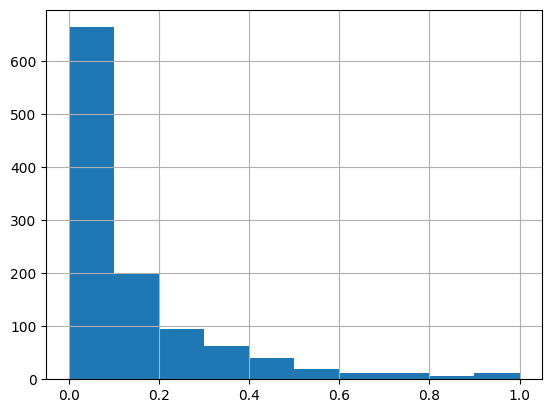

In [39]:
pd.Series(predCB).hist()

<Axes: >

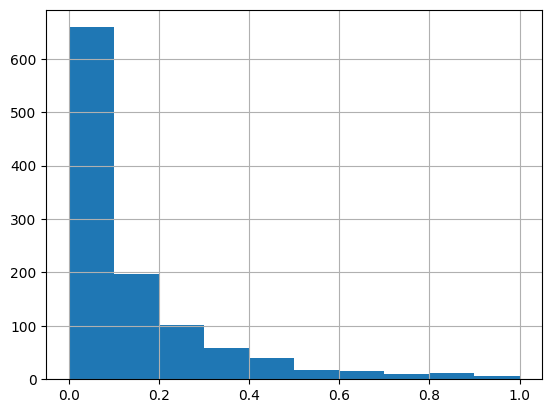

In [40]:
pd.Series(predXB).hist()

<Axes: >

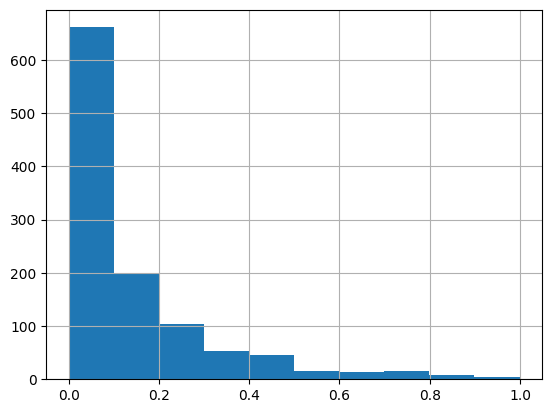

In [41]:
pd.Series(predLB).hist()

<Axes: >

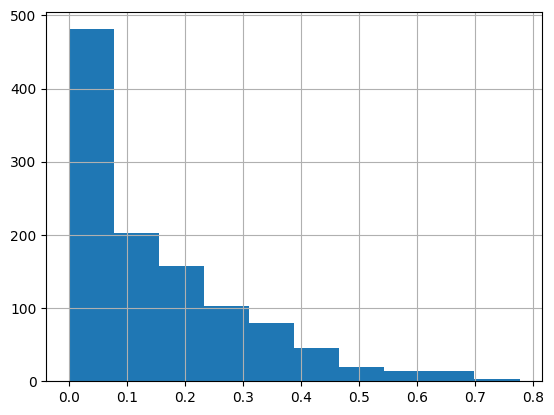

In [42]:
pd.Series(predLR).hist()

<Axes: >

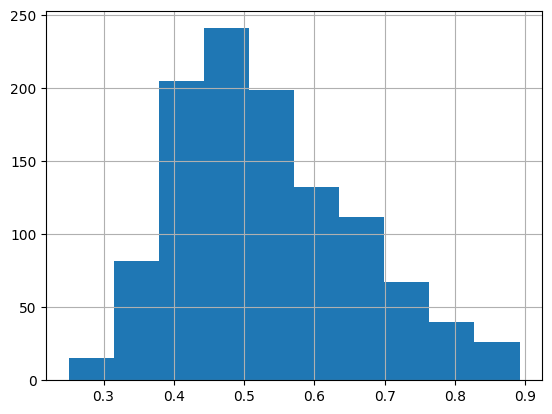

In [44]:
pd.Series(predNN).hist()

<Axes: >

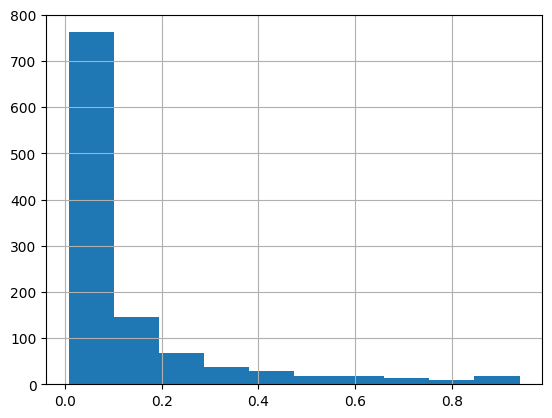

In [45]:
pd.Series(predCBC).hist()

<Axes: >

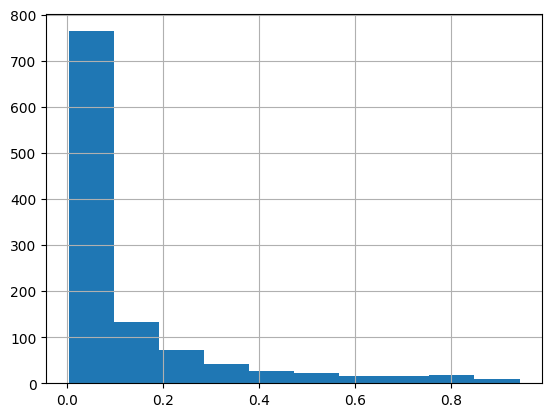

In [46]:
pd.Series(predXBC).hist()

<Axes: >

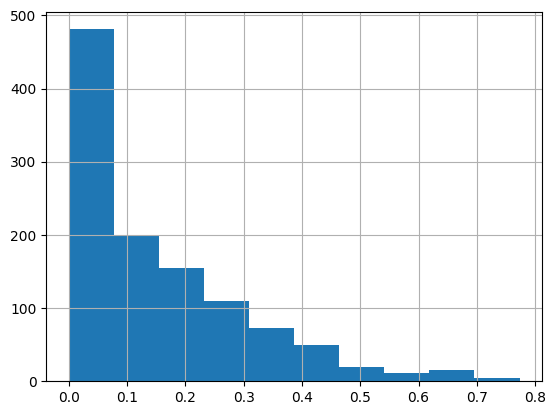

In [47]:
pd.Series(predR).hist()

<Axes: >

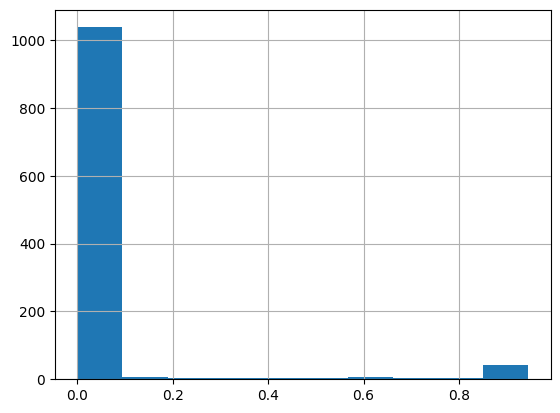

In [48]:
pd.Series(predLBC).hist()

<Axes: >

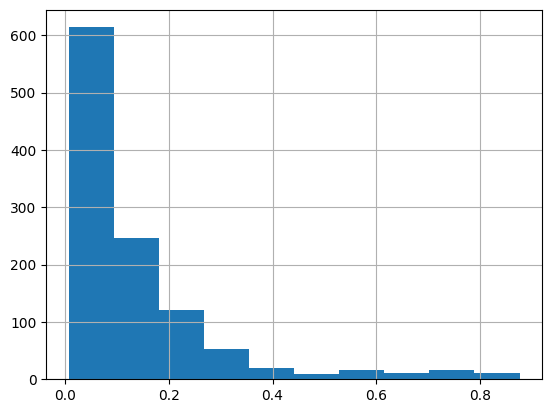

In [49]:
pd.Series(pred).hist()

# Making Submission

In [50]:
submission['Attrition'] = pred
submission

,id,Attrition
0,1677,0.174357
1,1678,0.207900
2,1679,0.042246
3,1680,0.090700
4,1681,0.583838
...,...,...
1114,2791,0.130605
1115,2792,0.011644
1116,2793,0.026108
1117,2794,0.068236


In [51]:
submission.to_csv('submission.csv', index=False)